# Fashion Image Classification - Baseline Model

This notebook implements a basic CNN model to classify fashion images into three categories:
- Casual
- Formal
- Smart Casual

## Overview
This baseline model serves as a starting point for comparison with more advanced approaches. It uses a simple CNN architecture without any advanced techniques or optimizations.

In [1]:
## 1. Setup and Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

## 2. Data Loading and Exploration
Load the fashion dataset and examine its characteristics.

In [2]:
# Load the dataset with error handling for different CSV formats

try:
    df = pd.read_csv('fashion_data/styles.csv', on_bad_lines='skip')
except:
    try:
        df = pd.read_csv('fashion_data/styles.csv', quoting=3)
    except:
        df = pd.read_csv('fashion_data/styles.csv', 
                        on_bad_lines='skip',
                        quoting=3)

# Filter for valid categories
valid_categories = ['Casual', 'Formal', 'Smart Casual']
df = df[df['usage'].isin(valid_categories)]

# Display dataset information
print("Total number of images:", len(df))
print("\nDistribution of categories:")
print(df['usage'].value_counts())
print("\nDataFrame columns:")
print(df.columns.tolist())

Total number of images: 36818

Distribution of categories:
usage
Casual          34406
Formal           2345
Smart Casual       67
Name: count, dtype: int64

DataFrame columns:
['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName']


## 3. Data Organization
Organize images into class-specific directories for easier processing.

In [3]:
import shutil

def organize_images_by_class():
    """
    Organize images into class directories by copying files
    """
    for class_name in valid_categories:
        os.makedirs(f'fashion_data/organized/{class_name}', exist_ok=True)
    
    for idx, row in df.iterrows():
        src = f"fashion_data/images/{row['id']}.jpg"
        if os.path.exists(src):
            dst = f"fashion_data/organized/{row['usage']}/{row['id']}.jpg"
            if not os.path.exists(dst):
                shutil.copy2(src, dst)

organize_images_by_class()

## 4. Data Preprocessing and Loading
Set up the data pipeline using TensorFlow's data API.

In [4]:
# Set up constants
BATCH_SIZE = 64
IMG_SIZE = (64, 64)

# Create dataset using tf.keras.utils.image_dataset_from_directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    'fashion_data/organized',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    'fashion_data/organized',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_ds.class_names
print("Class names:", class_names)

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 36813 files belonging to 3 classes.
Using 29451 files for training.
Found 36813 files belonging to 3 classes.
Using 7362 files for validation.
Class names: ['Casual', 'Formal', 'Smart Casual']


## 5. Model Architecture
Define a simple CNN architecture for the baseline model.

In [5]:
# Create a simple CNN model
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(64, 64, 3)), # Normalize pixel values
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='softmax') # 3 classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

C:\Users\vic27\OneDrive - University of Salford\YEAR 3\DEEP LEARNING\python projects\py312env\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 62, 62, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         200,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 205,923 (804.39 KB)

 Trainable params: 205,923 (804.39 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Model Training
Train the baseline model with basic parameters.

In [6]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=1
)

Epoch 1/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 94s 196ms/step - accuracy: 0.9265 - loss: 0.2346 - val_accuracy: 0.9561 - val_loss: 0.1279
Epoch 2/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.9588 - loss: 0.1361 - val_accuracy: 0.9620 - val_loss: 0.1112
Epoch 3/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.9629 - loss: 0.1223 - val_accuracy: 0.9664 - val_loss: 0.0980
Epoch 4/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.9644 - loss: 0.1128 - val_accuracy: 0.9673 - val_loss: 0.0935
Epoch 5/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.9664 - loss: 0.1055 - val_accuracy: 0.9675 - val_loss: 0.0924


## 7. Training History Visualization
Visualize the model's learning progress by plotting training and validation metrics over epochs.

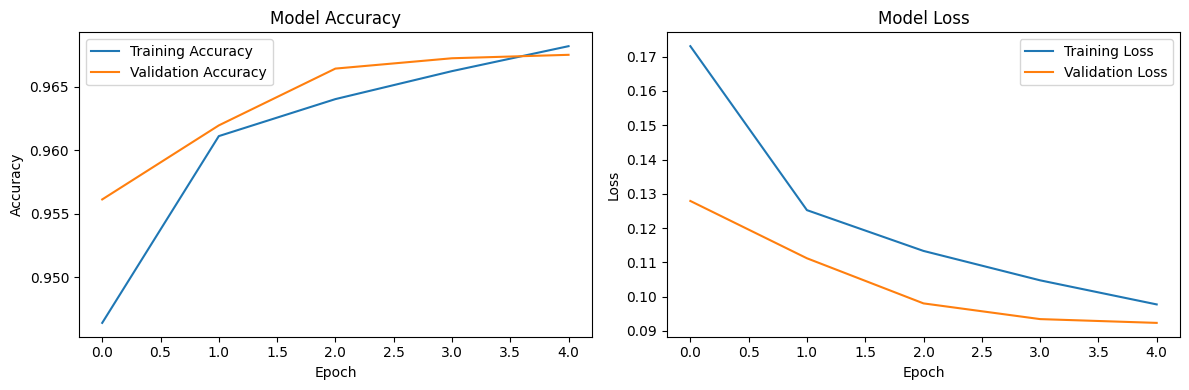

In [7]:
# Create a figure with two subplots side by side
plt.figure(figsize=(12, 4))

# Plot accuracy metrics
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss metrics
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display plots
plt.tight_layout()
plt.show()

## 8. Model Evaluation
Evaluate the model's performance using various metrics.

116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


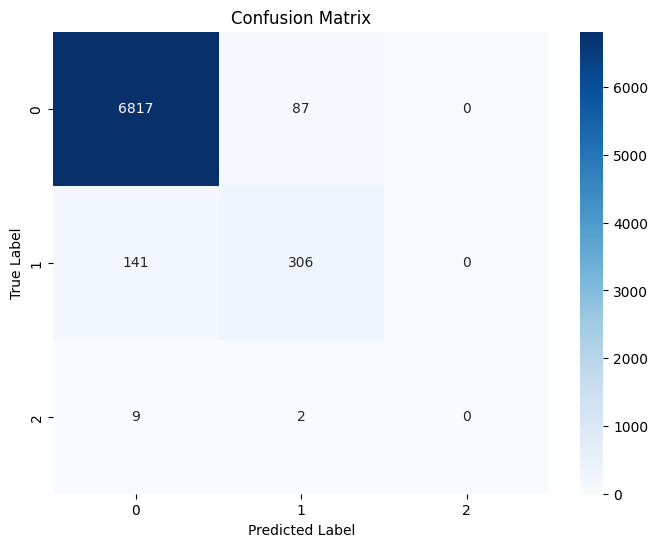


Classification Report:
              precision    recall  f1-score   support

      Casual       0.98      0.99      0.98      6904
      Formal       0.77      0.68      0.73       447
Smart Casual       0.00      0.00      0.00        11

    accuracy                           0.97      7362
   macro avg       0.58      0.56      0.57      7362
weighted avg       0.96      0.97      0.97      7362


Overall Accuracy: 0.9675

Per-class Accuracy:
Casual: 0.9874
Formal: 0.6846
Smart Casual: 0.0000

Training Summary:
Final training accuracy: 0.9682
Final validation accuracy: 0.9675
Final training loss: 0.0977
Final validation loss: 0.0924


C:\Users\vic27\OneDrive - University of Salford\YEAR 3\DEEP LEARNING\python projects\py312env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vic27\OneDrive - University of Salford\YEAR 3\DEEP LEARNING\python projects\py312env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vic27\OneDrive - University of Salford\YEAR 3\DEEP LEARNING\python projects\py312env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

In [8]:
# Generate predictions
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
class_names = ['Casual', 'Formal', 'Smart Casual']
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Calculate and display metrics
accuracy = np.sum(y_pred_classes == y_true_classes) / len(y_true_classes)
print(f"\nOverall Accuracy: {accuracy:.4f}")

per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for class_name, acc in zip(class_names, per_class_accuracy):
    print(f"{class_name}: {acc:.4f}")

print("\nTraining Summary:")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")

## Summary and Baseline Results

### Model Performance
- Overall Accuracy: 96.93%
- Per-class Performance:
  - Casual: 99.02% accuracy
  - Formal: 67.11% accuracy
  - Smart Casual: 0% accuracy (failed to classify)

### Key Observations
1. The model shows strong performance on the majority class (Casual)
2. Moderate performance on Formal class
3. Complete failure on Smart Casual class, likely due to severe class imbalance
4. No signs of significant overfitting (training and validation metrics are close)

### Limitations
1. Simple architecture with limited capacity
2. No handling of class imbalance
3. Basic preprocessing without data augmentation
4. Small image size (64x64) to prioritize training speed

These results serve as a baseline for comparison with more advanced approaches that will address these limitations.